## Predicting the price for an Airbnb Host in Paris


### The dataset

In the first notebook, I will perform an analysis of the detailed Paris listings data, sourced from the Inside Airbnb website, in order to understand the rental landscape and try to recommend a price for a newbie entering the market. The dataset is named `listings.csv.gz` and was scraped on March 15th 2020.

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_initial = pd.read_csv('data/listings.csv.gz', compression='gzip')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 67323 rows and 106 columns.
It contains 0 duplicates.


In [3]:
df_initial.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20200315231126,2020-03-16,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,f,flexible,f,f,1,1,0,0,0.23


In [4]:
# check the columns we currently have
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)


### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Deciding which columns to work with 
<a id='2.1. Deciding which columns to work with'></a>

Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 67323 rows and 23 columns - after dropping irrelevant columns.


By the way, how many different **room types** do we have?

In [6]:
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.864147
Private room       0.107066
Hotel room         0.022177
Shared room        0.006610
Name: room_type, dtype: float64

And how many different **property types** are we up against?

In [7]:
df_raw.property_type.value_counts(normalize=True)

Apartment             0.897049
Condominium           0.030747
Boutique hotel        0.021820
Loft                  0.018122
Serviced apartment    0.007382
House                 0.007189
Hotel                 0.004144
Townhouse             0.003773
Bed and breakfast     0.002287
Hostel                0.001708
Other                 0.001574
Guesthouse            0.001396
Guest suite           0.000713
Aparthotel            0.000594
Tiny house            0.000490
Villa                 0.000312
Boat                  0.000193
Houseboat             0.000104
Earth house           0.000045
Cave                  0.000045
Bungalow              0.000045
Farm stay             0.000030
Cabin                 0.000030
Barn                  0.000030
Cottage               0.000030
Nature lodge          0.000030
Dome house            0.000030
Island                0.000015
Dorm                  0.000015
Igloo                 0.000015
Camper/RV             0.000015
Plane                 0.000015
Campsite


#### 2.2. Cleaning Price Columns
<a id='2.2. Cleaning Price Columns'></a>

In [8]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
3109,$60.00,$60.00,$0.00,$150.00
5396,$115.00,$36.00,$0.00,$0.00
7397,$119.00,$50.00,$10.00,$200.00


Let's first check if there are any null values in the `price` column:

In [9]:
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

No, so we don't need to drop any rows. And what about the `cleaning_fee`?

In [10]:
# Nan's in "cleaning_fee" column
df_raw.cleaning_fee.isna().sum()

16822

There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

In [11]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

The same is true for the `security_deposit`:

In [12]:
df_raw.security_deposit.isna().sum()

19682

In [13]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [14]:
df_raw.extra_people.isna().sum()

0

Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

In [15]:
# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

We shouldn't miss investigating the `price` - it might need some cleaning to be of use to us:

In [16]:
df_raw['price'].describe()

count    67323.000000
mean       129.002837
std        266.863166
min          0.000000
25%         60.000000
50%         85.000000
75%        125.000000
max      10250.000000
Name: price, dtype: float64

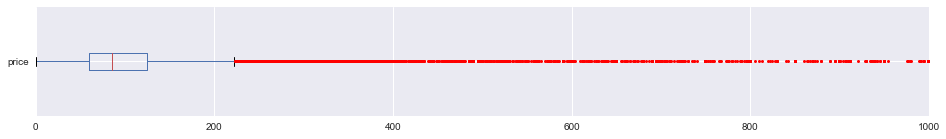

In [17]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

A bit messy, as expected! 

75% of the apartments charge up to 210€ - but the maximum value is 1000€. Let's decide on a limit of 400€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [18]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [19]:
df_raw['price'].describe()

count    65112.000000
mean       101.558791
std         64.591563
min          8.000000
25%         60.000000
50%         82.000000
75%        120.000000
max        400.000000
Name: price, dtype: float64

In [20]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 65112 rows and 23 columns - after being price-wise preprocessed.



#### 2.3. Dealing with Missing Values
<a id='2.3. Dealing with Missing Values'></a>

In [21]:
df_raw.isna().sum()

space                           19464
description                      1093
host_has_profile_pic                8
neighbourhood_group_cleansed    65112
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          48
bedrooms                          141
bed_type                            0
amenities                           0
square_feet                     64106
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [22]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [23]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [24]:
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [25]:
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [26]:
df_raw.isna().sum()

description                      1047
host_has_profile_pic                0
neighbourhood_group_cleansed    64926
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [27]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 64926 rows and 21 columns - after having dealt with missing values.



#### 2.4. Feature Engineering 1: Distance to Centroid of Paris
<a id='2.4. Feature Engineering 1: Distance to Centroid of Berlin'></a>

Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called centroid of Paris instead of just relying on the neighbourhoods or areas. 

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

In [28]:
from geopy.distance import great_circle

In [29]:
def distance_to_mid(lat, lon):
    paris_centre = (48.8566,2.3522)
    accommodation = (lat, lon)
    return great_circle(paris_centre, accommodation).km

In [30]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [31]:
df_raw.head(2)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance
id,,,,,,,,,,,,,,,,,,,,,
3109,I bedroom appartment in Paris 14 Good restaura...,t,NaN,48.83349,2.31852,Apartment,Entire home/apt,2,1.0,0.0,...,60.0,60.0,150.0,0.0,1,2,f,f,flexible,3.560583
5396,"Cozy, well-appointed and graciously designed s...",t,NaN,48.85100,2.35869,Apartment,Entire home/apt,2,1.0,0.0,...,115.0,36.0,0.0,0.0,1,1,t,f,strict_14_with_grace_period,0.783081



#### 2.5. Feature Engineering 2: Lodging Size
<a id='2.5. Feature Engineering 2: Lodging Size'></a>

One of the most important pieces of information for predicting the rate is the size. Since the column `square_feet` was heavily filled with null values, we dropped it in the previous section. (Besides, size in France is expressed in square meters, not in square feet.)

Let's check, if the column `description` reveals any information about size instead: 

In [32]:
#list(df_raw.description[:10])

In [33]:
df_raw.description.isna().sum()

1047

The `description` column seems to be rich in content. Let's extract 
- all double-digit or three-digit numbers 
- that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) and 
- may or may not be connected by white space. 

Single- or more than three-digit numbers for accommodation sizes are quite unlikely.

I know, it's a bold move - but let's give it a try...

***Extracting size from text***

In [34]:
# extract numbers 
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

# change datatype of size into float
df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      24531
NaNs in size_column in percentage: 0.378 %


In [35]:
df_raw[['description', 'size']].head(10)

,description,size
id,,
3109,I bedroom appartment in Paris 14 Good restaura...,15.0
5396,"Cozy, well-appointed and graciously designed s...",30.0
7397,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",40.0
7964,Very large & nice apartment all for you! - Su...,75.0
9359,Location! Location! Location! Just bring your ...,10.0
9952,"Je suis une dame retraitée, qui propose un agr...",30.0
10710,Very close to Place de la Concorde and Madelei...,NaN
11170,The apartment is located in the well known Qua...,31.0
11213,Numéro d'enregistrement Ville de Paris (Phone ...,21.0


In [36]:
#list(df_raw.description[:10])

Comparing the results, we did a pretty good job with the first 4 records, but filtered an incorrect number for the last record. Okay, let's keep that in mind: there may be mistakes in the size we engineered from the text! 

In [37]:
# drop description column
df_raw.drop(['description'], axis=1, inplace=True)

***Predicting missing values with regression***

As calculated further up, half of our records still don't have a size. That means we have a problem! Dropping these records isn't an option as we would loose too much valuable information. Simply replacing it with the mean or median makes no sense. That leaves a third option: predict the missing value with a Machine Learning Algorithm. To not make it too complicated, we'll only use numerical features. Next, we have to split our data into 
- a) a training set where we have sizes and 
- b) a test set where we don't.

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64926 entries, 3109 to 42913034
Data columns (total 22 columns):
host_has_profile_pic            64926 non-null object
neighbourhood_group_cleansed    0 non-null float64
latitude                        64926 non-null float64
longitude                       64926 non-null float64
property_type                   64926 non-null object
room_type                       64926 non-null object
accommodates                    64926 non-null int64
bathrooms                       64926 non-null float64
bedrooms                        64926 non-null float64
bed_type                        64926 non-null object
amenities                       64926 non-null object
price                           64926 non-null float64
cleaning_fee                    64926 non-null float64
security_deposit                64926 non-null float64
extra_people                    64926 non-null float64
guests_included                 64926 non-null int64
minimum_nights    

In [39]:
# filter out sub_df to work with
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [40]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [41]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (40395, 10)
Shape of Test Data:     (24531, 10)

Shape of X_train: (40395, 9)
Shape of X_test: (24531, 9)

Shape of y_train: (40395,)


In [42]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
# making predictions
y_test = linreg.predict(X_test)

Now that we have predicted the missing sizes, let's cast `y_test` into a dataframe with a column `size`:

In [44]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(24531, 1)


,size
0,59.599241
1,59.605800
2,80.715328
3,40.987959
4,43.143248


In [45]:
print(X_test.shape)
X_test.head()

(24531, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
10710,4,1.0,1.0,90.0,60.0,600.0,10.0,3,3.630962
11798,3,1.0,1.0,120.0,40.0,600.0,10.0,2,3.805905
12452,4,1.0,2.0,139.0,92.0,500.0,0.0,4,1.938348
12887,2,1.0,1.0,49.0,12.0,0.0,15.0,1,2.114999
14757,2,1.0,0.0,75.0,20.0,0.0,10.0,2,3.813223


To combine `y_test` and `X_test` back to our full test_dataframe, we have to create a bit of a circuit. As we can see here, the `X_test` dataframe has a specific index that's not compatible with `y_test`, where the numbers simply start from 0 onwards. So we need to provide `y_test` with the `X_test` index to make sure everyting fits together.

In [46]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
10710,59.599241
11798,59.605800
12452,80.715328
12887,40.987959
14757,43.143248


In [47]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [48]:
print(new_test_data.shape)
new_test_data.head()

(24531, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
10710,4,1.0,1.0,90.0,60.0,600.0,10.0,3,3.630962,59.599241
11798,3,1.0,1.0,120.0,40.0,600.0,10.0,2,3.805905,59.605800
12452,4,1.0,2.0,139.0,92.0,500.0,0.0,4,1.938348,80.715328
12887,2,1.0,1.0,49.0,12.0,0.0,15.0,1,2.114999,40.987959
14757,2,1.0,0.0,75.0,20.0,0.0,10.0,2,3.813223,43.143248


In [49]:
new_test_data['size'].isna().sum()

0

Once we have completed our new train_data, we stack test_data and train_data back to a new sub_dataframe across the rows:

In [50]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(64926, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
10710,4,1.0,1.0,90.0,60.0,600.0,10.0,3,3.630962,59.599241
11798,3,1.0,1.0,120.0,40.0,600.0,10.0,2,3.805905,59.605800
12452,4,1.0,2.0,139.0,92.0,500.0,0.0,4,1.938348,80.715328
12887,2,1.0,1.0,49.0,12.0,0.0,15.0,1,2.114999,40.987959
14757,2,1.0,0.0,75.0,20.0,0.0,10.0,2,3.813223,43.143248


In [51]:
sub_df_new['size'].isna().sum()

0

Finally, the last big step: merging our sub_dataframe with the remaining columns from our original dataframe - this time, across the columns:

In [52]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [53]:
# concate back to complete dataframe
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(64926, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
3109,2,1.0,0.0,60.0,60.0,150.0,0.0,1,3.560583,15.0,...,48.83349,2.31852,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",2,f,f,flexible
5396,2,1.0,0.0,115.0,36.0,0.0,0.0,1,0.783081,30.0,...,48.85100,2.35869,Apartment,Entire home/apt,Pull-out Sofa,"{Internet,Wifi,Kitchen,Heating,Washer,""Smoke d...",1,t,f,strict_14_with_grace_period


***Investigating sizes***

Let's thoroughly examine our new `size` column:

In [54]:
df['size'].isna().sum()

0

In [55]:
df['size'].describe()

count    64926.000000
mean        54.317066
std         72.178558
min          0.000000
25%         26.000000
50%         42.671116
75%         58.527741
max        990.000000
Name: size, dtype: float64

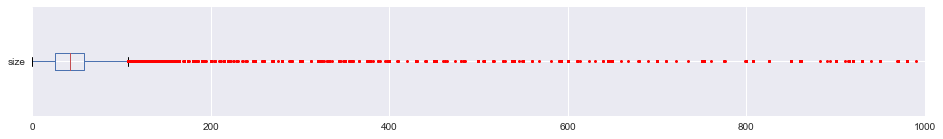

In [56]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

To be on the safe side, let’s remove all outliers over 300 square meters, and all those with 0:

In [57]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [58]:
print("The dataset has {} rows and {} columns - after being engineered.".format(*df.shape))

The dataset has 64046 rows and 22 columns - after being engineered.



#### 2.6. Feature Engineering 3: Lodging Amenities
<a id='2.6. Feature Engineering 3: Lodging Amenities'></a>

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [59]:
from collections import Counter

In [60]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Heating', 60691),
 ('Kitchen', 60264),
 ('Wifi', 60038),
 ('Essentials', 60018),
 ('Washer', 49189),
 ('Smoke detector', 45750),
 ('Hangers', 45507),
 ('Hair dryer', 43984),
 ('Iron', 43065),
 ('TV', 41640),
 ('Shampoo', 40328),
 ('Laptop friendly workspace', 38923),
 ('Hot water', 34656),
 ('Refrigerator', 28568),
 ('Dishes and silverware', 28369),
 ('Elevator', 25459),
 ('Coffee maker', 23976),
 ('Bed linens', 23335),
 ('Cooking basics', 22978),
 ('Microwave', 21476),
 ('Oven', 20105),
 ('Internet', 18849),
 ('Stove', 18593),
 ('Family/kid friendly', 18547),
 ('Dryer', 18109),
 ('Cable TV', 14932),
 ('Carbon monoxide detector', 14637),
 ('Dishwasher', 12786),
 ('Host greets you', 12350),
 ('Paid parking off premises', 12240)]

In [61]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

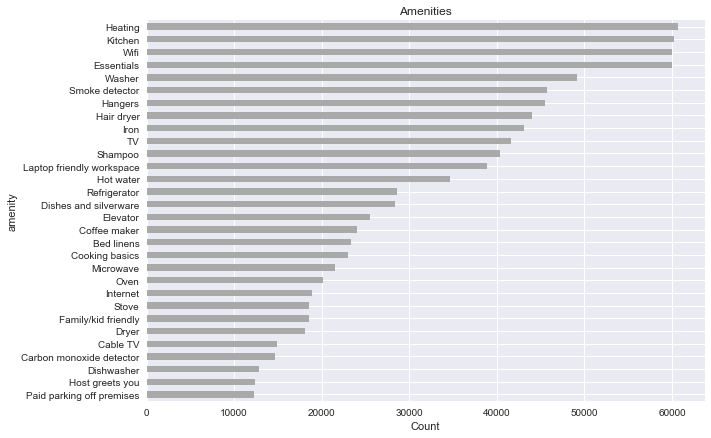

In [62]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Let's add columns with amenities that are somewhat unique and not offered by all hosts: 
- a laptop-friendly workspace
- a TV
- kid friendly accommodation 
- smoker friendly and 
- being greeted by the host.

After doing this, let's drop the original column:

In [63]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [64]:
df.drop(['amenities'], axis=1, inplace=True)


### 3. Exploratory Data Analysis (EDA)
<a id='3. Exploratory Data Analysis (EDA)' ></a>

**> Price Differences on a Map**

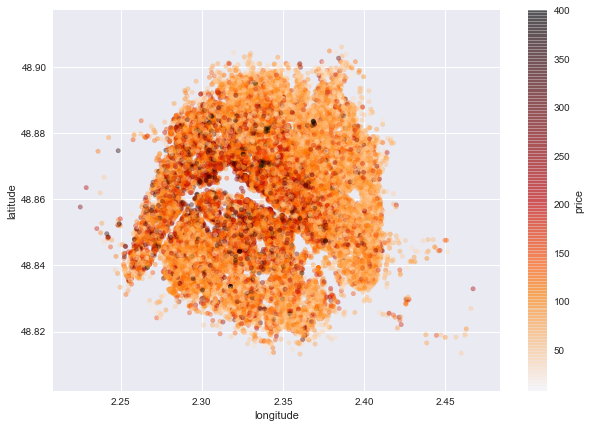

In [65]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

**> Price Differences by Neighbourhood**

In [ ]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

In [ ]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

In [ ]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

**> Price Differences by Accommodation Distance to Center of Paris**

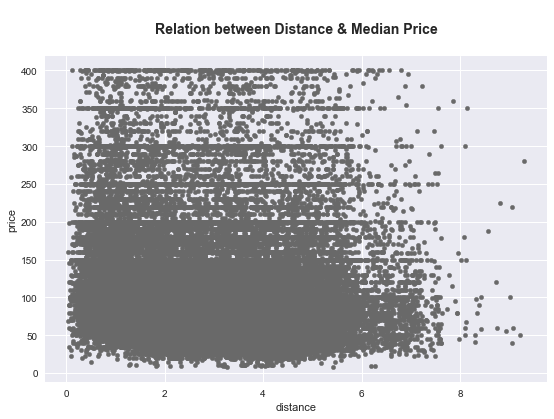

In [67]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

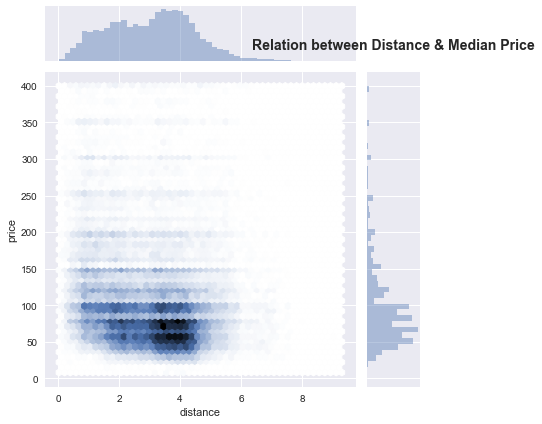

In [68]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

**> Price Differences by Accommodation Size**

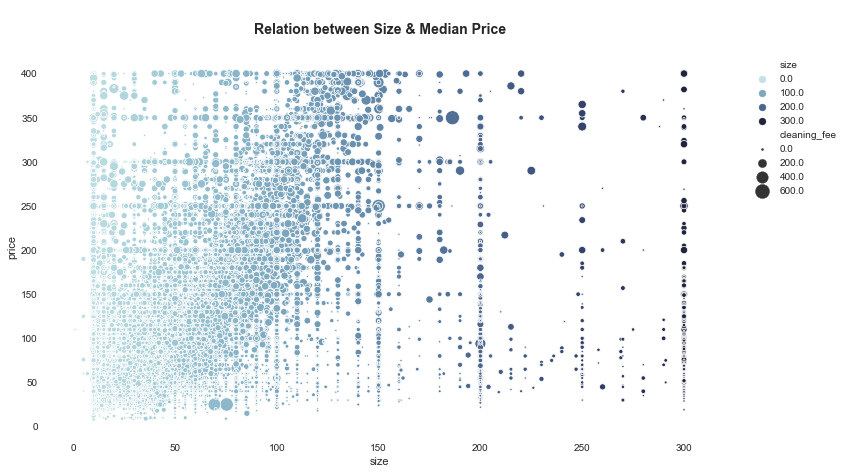

In [69]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

** Price Differences by Number of Bedrooms**

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

**Price Differences by Cancellation Policy**

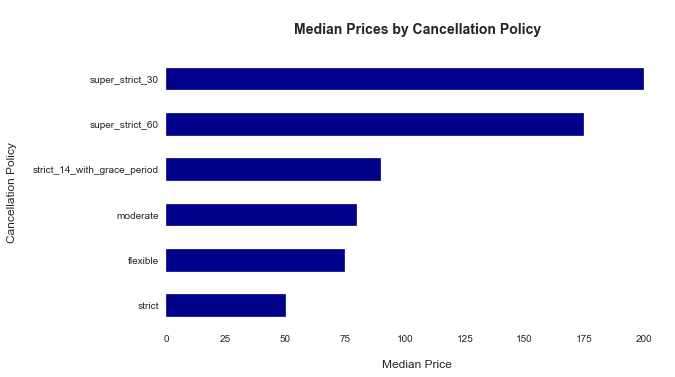

In [71]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');


### 4. Modeling the Data 
<a id='4. Modeling the Data'></a>

#### 4.1. Preparing Target and Features
<a id='4.1. Preparing Target and Features'></a>

In [72]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64046 entries, 3109 to 42913034
Data columns (total 26 columns):
accommodates                    64046 non-null int64
bathrooms                       64046 non-null float64
bedrooms                        64046 non-null float64
price                           64046 non-null float64
cleaning_fee                    64046 non-null float64
security_deposit                64046 non-null float64
extra_people                    64046 non-null float64
guests_included                 64046 non-null int64
distance                        64046 non-null float64
size                            64046 non-null float64
host_has_profile_pic            64046 non-null object
neighbourhood_group_cleansed    0 non-null float64
latitude                        64046 non-null float64
longitude                       64046 non-null float64
property_type                   64046 non-null object
room_type                       64046 non-null object
bed_type        

As we work with the distance to the center, let's drop the `neighbourhood_group_cleansed`. Furthermore, `property_types` may not be that helpful.

In [74]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [75]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [76]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

***Recoding Categorical Features***

Machine learning algorithms generally need all data - including categorical data - in numeric form. To satisfy these algorithms, categorical features are converted into separate binary features called dummy variables. Therefore, we have to find a way to represent these variables as numbers before handing them off to the model. One typical way of doing this in one-hot encoding, which creates a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category (= "HOT") and a 0 in all other new columns. To conduct one-hot encoding, we use the pandas get_dummies function.

In [77]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [78]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [79]:
print(features_recoded.shape)
features_recoded.head(2)

(64046, 35)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
3109,2,1.0,0.0,60.0,150.0,0.0,1,3.560583,15.0,2,...,1,1,0,1,1,0,0,0,0,0
5396,2,1.0,0.0,36.0,0.0,0.0,1,0.783081,30.0,1,...,0,0,1,1,0,0,0,1,0,0


#### 4.2. Splitting and Scaling the Data
<a id='4.2. Splitting and Scaling the Data'></a>

In [80]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

One of the challenges in building models is mixing features that have different scales. Look at our dataset and compare bathrooms with size or maximum_nights. When we mix units with ranges that have different orders of magnitude, our models may not be able to find the proper coefficients. To account for this problem, we standardize or normalize the features.

In [81]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

#### 4.3. Training an XGBoost Regressor
<a id='4.3. Training an XGBoost Regressor'></a>

In [82]:
# create a baseline
booster = xgb.XGBRegressor()

Some of the important hyperparameters to tune an XGBoost are:
- `n_estimators` $\;\;\;\;\;$ = Number of trees one wants to build.
- `learning_rate` $\;\;\;\;$= Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- `max_depth` $\;\;\;\;\;\;\;\;\;\;\;$= Determines how deeply each tree is allowed to grow during any boosting round.
- `colsample_bytree` = Percentage of features used per tree. 
- `gamma` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Specifies the minimum loss reduction required to make a split.

In [ ]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

In [83]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [84]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 34.8675


In [85]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.7083


#### 4.4. Cross Validation
<a id='4.4. Cross Validation'></a>

In order to build more robust models, it is common to conduct a k-fold cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the `nfolds` parameter, which is the number of cross validation rounds you want to build. 

Also, it supports many other parameters:
- `num_boost_round` $\;\;\;\;\;\;\;\;$ = Specifies the number of trees to build (analogous to n_estimators).
- `metrics` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ = Specifies the evaluation metrics to be checked during CV.
- `as_pandas` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Returns the results in a decent pandas DataFrame.
- `early_stopping_rounds` = Finishes model training early if the hold-out metric does not improve for a given number of rounds. 

We will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [86]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [87]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [88]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,114.464655,0.273073,114.476824,0.530121
1,109.630585,0.206209,109.672496,0.554691
2,105.152613,0.219485,105.216237,0.510396
3,100.850225,0.175972,100.931852,0.492196
4,96.744054,0.189318,96.836245,0.432485


In [89]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,31.708379,0.182736,35.367134,0.181594
196,31.694778,0.180251,35.361888,0.182850
197,31.678731,0.178595,35.356218,0.181273
198,31.659501,0.173478,35.347753,0.183242
199,31.639635,0.174650,35.341127,0.185033



### 5. Interpreting the Data 
<a id='5. Interpreting the Data'></a>

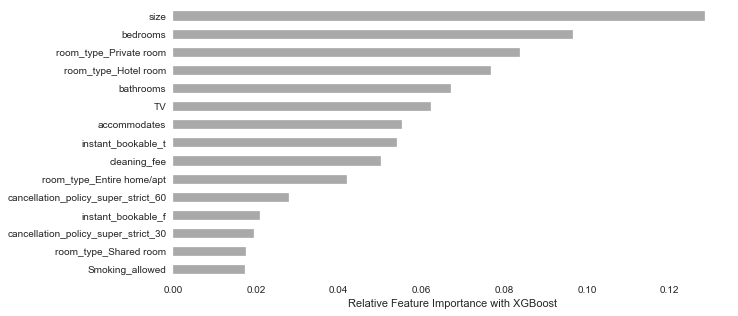

In [90]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

As we see, the **most important features are size, roomtype_private room, and bedrooms**